# Feature Engineering - Handling Region Feature 

In [1]:
import pandas as pd
import numpy as np
import re

import geopandas as gpd #conda install geopandas
# conda install -c conda-forge nbformat

import plotly.express as px #conda install -c plotly plotly_express
from plotly.express import choropleth_mapbox
from shapely.geometry import shape, Point
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import folium
# from IPython.display import SVG

from tokens import mapbox_token

import warnings
warnings.filterwarnings("ignore")

## 1. Loading in Data

In [2]:
df_restaurant = pd.read_csv("data/full_restaurant_rating_data.csv")
df_is_in_mall = pd.read_csv("data/restaurant_is_in_mall.csv")
df_walking_duration_from_station_exit = pd.read_csv("data/restaurant_walking_duration_from_station_exit.csv")
df_restaurant_nearest_exit = pd.read_csv('data/restaurant_nearest_station_exit.csv')

In [3]:
subset_columns = [
    'name',
    'address',
    'region',
    'latitude',
    'longitude',
    'overall_rating',
    'num_of_reviews',
    'url'
]

df_restaurant_subset = df_restaurant[subset_columns].copy()

In [4]:
df_restaurant_subset = df_restaurant_subset.merge(df_is_in_mall[['url', 'is_in_mall', 'mall']], on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_walking_duration_from_station_exit, on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_restaurant_nearest_exit[['station_name', 'station_line_color', 'url', 'distance']], on='url', how='left')

### Drop Missing Ratings

In [5]:
############# Drop Ratings = -1
df_restaurant_subset = df_restaurant_subset[df_restaurant_subset['overall_rating'] != -1].copy()

print('Percentage of Restaurants:')
df_restaurant_subset['overall_rating'].value_counts().sort_index() / len(df_restaurant_subset) * 100 

Percentage of Restaurants:


1.0     0.775675
1.5     0.330955
2.0     1.385872
2.5     2.347709
3.0    10.662943
3.5    19.857276
4.0    37.832247
4.5    17.581963
5.0     9.225359
Name: overall_rating, dtype: float64

### [KIV] Taking into account restaurants with more than 8 reviews

In [6]:
df_restaurant_subset['num_of_reviews'].describe()

count    9669.000000
mean       46.610818
std       149.768247
min         1.000000
25%         2.000000
50%         8.000000
75%        31.000000
max      7148.000000
Name: num_of_reviews, dtype: float64

In [7]:
df_num_of_reviews_capped = df_restaurant_subset[df_restaurant_subset['num_of_reviews'] >= 8].copy()

########### Potentially: 4.5 / 5.0: Outstanding, 4.0: Average, 3.5 and below: Below Average
print(f"Total Observations: {len(df_num_of_reviews_capped)}")
print(f"Below Average: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] < 4.0]) * 100 / len(df_num_of_reviews_capped)}%")
print(f"Average: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] == 4.0]) * 100 / len(df_num_of_reviews_capped)}%")
print(f"Outstanding: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] >= 4.5]) * 100 / len(df_num_of_reviews_capped)}%")

Total Observations: 4981
Below Average: 36.07709295322224%
Average: 42.88295522987352%
Outstanding: 21.039951816904235%


### [KIV] Dropping Rows with missing Walking Distance

In [8]:
print(f"Total Rows: {len(df_num_of_reviews_capped)}")
print(f"Good Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] > 100])}")
print(f"Bad Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] < 100])}")
print(f"Missing Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'].isna()])}")
print(f"Missing Walking Distance: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['walking_distance'].isna()])}")

Total Rows: 4981
Good Geolocations: 4969
Bad Geolocations: 0
Missing Geolocations: 12
Missing Walking Distance: 13


In [9]:
df_num_of_reviews_capped = df_num_of_reviews_capped.dropna(subset=['walking_distance'])

In [10]:
print(f"Total Rows: {len(df_num_of_reviews_capped)}")
print(f"Good Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] > 100])}")
print(f"Bad Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] < 100])}")
print(f"Missing Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'].isna()])}")
print(f"Missing Walking Distance: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['walking_distance'].isna()])}")

Total Rows: 4968
Good Geolocations: 4968
Bad Geolocations: 0
Missing Geolocations: 0
Missing Walking Distance: 0


## 2. Exploring Region feature scraped from TripAdvisor

- Problematic Feature

In [11]:
# No clear assignment of region names by TripAdvisor --> Many regions like City Hall, Marina Bay, Central Business District can be assigned to Central Area/City Area

print(f"Total Number of TripAdvisor Regions: {len(df_num_of_reviews_capped['region'].value_counts())}")
print("Percentage of Restaurants in these regions:")
print(df_num_of_reviews_capped['region'].value_counts().head(10) / len(df_num_of_reviews_capped) * 100)

Total Number of TripAdvisor Regions: 125
Percentage of Restaurants in these regions:
Central Area/City Area    20.954106
Outram                    10.104670
Boulevard                  5.132850
Bukit Merah                3.985507
Somerset                   3.603060
Marine Parade              3.059581
Marina Centre              2.999195
City Hall                  2.495974
Changi                     2.475845
Bedok                      2.214171
Name: region, dtype: float64


## 3. Using Geospatial Visualisation to curate "new" Region feature

Convert dataframe into a Geodataframe

In [12]:
gdf_restaurant = gpd.GeoDataFrame(df_num_of_reviews_capped, geometry= gpd.points_from_xy(df_num_of_reviews_capped['longitude'], df_num_of_reviews_capped['latitude']), crs='epsg:4326')

Reading in a Subzones data

- 3 Levels of Geographical Boundary: District -> Town -> Area

In [13]:
gdf_subzones = gpd.read_file('data/singapore_subzones_2019.geojson', crs='epsg:4326')
gdf_subzones['extracted_description'] = gdf_subzones['Description'].apply(
    lambda x: re.findall("(?<=<td>)[\w*\s*\-*]*\w+(?=</td>)", x)
)

def extract_district(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[1]
        else:
            np.nan
    else:
        return np.nan

def extract_town(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[4]
        else:
            return x[3]
    else:
        return np.nan

def extract_region(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[6]
        else:
            return x[5]
    else:
        return np.nan

gdf_subzones['district'] = gdf_subzones['extracted_description'].apply(lambda x: extract_district(x))
gdf_subzones['town'] = gdf_subzones['extracted_description'].apply(lambda x: extract_town(x))
gdf_subzones['area'] = gdf_subzones['extracted_description'].apply(lambda x: extract_region(x))        

gdf_subzones.drop(columns=['Name', 'Description', 'extracted_description'], inplace=True)

In [14]:
gdf_subzones

,geometry,district,town,area
0,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880...",MARINA EAST,MARINA EAST,CENTRAL REGION
1,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837...",INSTITUTION HILL,RIVER VALLEY,CENTRAL REGION
2,"POLYGON Z ((103.83410 1.29248 0.00000, 103.834...",ROBERTSON QUAY,SINGAPORE RIVER,CENTRAL REGION
3,"MULTIPOLYGON Z (((103.71253 1.29163 0.00000, 1...",JURONG ISLAND AND BUKOM,WESTERN ISLANDS,WEST REGION
4,"POLYGON Z ((103.84718 1.29700 0.00000, 103.847...",FORT CANNING,MUSEUM,CENTRAL REGION
...,...,...,...,...
327,"POLYGON Z ((103.84263 1.36323 0.00000, 103.842...",UPPER THOMSON,BISHAN,CENTRAL REGION
328,"POLYGON Z ((103.83537 1.37093 0.00000, 103.835...",SHANGRI-LA,ANG MO KIO,NORTH-EAST REGION
329,"POLYGON Z ((103.84814 1.36879 0.00000, 103.848...",TOWNSVILLE,ANG MO KIO,NORTH-EAST REGION
330,"POLYGON Z ((103.84652 1.34521 0.00000, 103.846...",MARYMOUNT,BISHAN,CENTRAL REGION


Merging into Restaurant Dataset

In [15]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_subzones,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)

In [16]:
gdf_restaurant.head(3)

,name,address,region,latitude,longitude,overall_rating,num_of_reviews,url,is_in_mall,mall,walking_distance,walking_duration,station_name,station_line_color,distance,geometry,district,town,area
0,Alt Pizza,"60 Robertson Quay The Quayside 01-05, Singapor...",Robertson Quay,1.290260,103.83919,4.0,16,https://www.tripadvisor.com.sg/Restaurant_Revi...,False,NaN,744.5,536.0,FORT CANNING MRT STATION,BLUE,602.900720,POINT (103.83919 1.29026),ROBERTSON QUAY,SINGAPORE RIVER,CENTRAL REGION
1,Entre-Nous creperie,"27 Seah Street # 01-01, Singapore 188383 Singa...",Central Area/City Area,1.296215,103.85462,5.0,1488,https://www.tripadvisor.com.sg/Restaurant_Revi...,False,NaN,373.3,268.8,ESPLANADE MRT STATION,YELLOW,270.316449,POINT (103.85462 1.29621),BUGIS,DOWNTOWN CORE,CENTRAL REGION
2,The Courtyard,1 Fullerton Square Fullerton Hotel The Fullert...,Central Area/City Area,1.286365,103.85306,4.5,1420,https://www.tripadvisor.com.sg/Restaurant_Revi...,False,NaN,227.9,164.1,RAFFLES PLACE MRT STATION,GREEN,201.488769,POINT (103.85306 1.28636),CLIFFORD PIER,DOWNTOWN CORE,CENTRAL REGION


Handling Rows with Unmatched areas

In [17]:
gdf_restaurant_missing_location = gdf_restaurant[gdf_restaurant['area'].isna()].copy()
gdf_restaurant_missing_location

,name,address,region,latitude,longitude,overall_rating,num_of_reviews,url,is_in_mall,mall,walking_distance,walking_duration,station_name,station_line_color,distance,geometry,district,town,area
2537,Goldenbeach Seafood Paradise,907 East Coast Road #01-01 Springvale Springva...,NaN,1.391251,103.97471,4.0,27,https://www.tripadvisor.com.sg/Restaurant_Revi...,False,NaN,6161.8,4436.4,PASIR RIS MRT STATION,GREEN,3481.244390,POINT (103.97471 1.39125),NaN,NaN,NaN
2754,Rasa Istimewa,"6A Admiralty Road West Waterfront Park, Singap...",NaN,1.453914,103.77774,3.5,37,https://www.tripadvisor.com.sg/Restaurant_Revi...,False,NaN,2895.9,2085.0,WOODLANDS MRT STATION,RED,2116.644183,POINT (103.77774 1.45391),NaN,NaN,NaN
2815,Patro's Sports Bar & Restaurant,920 East Coast Parkway Parkland Green #01-18/1...,NaN,1.298121,103.90860,3.5,52,https://www.tripadvisor.com.sg/Restaurant_Revi...,False,NaN,3001.7,2161.2,EUNOS MRT STATION,GREEN,2441.963490,POINT (103.90860 1.29812),NaN,NaN,NaN


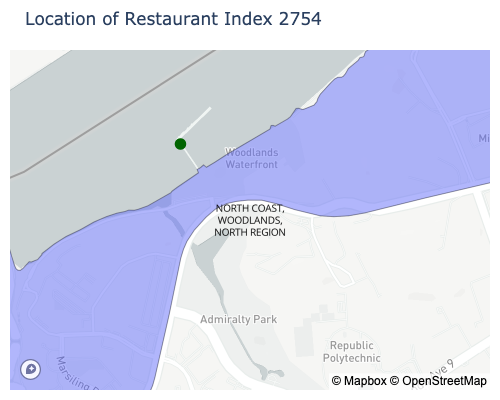

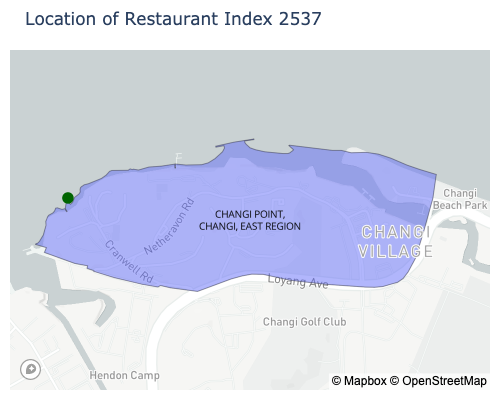

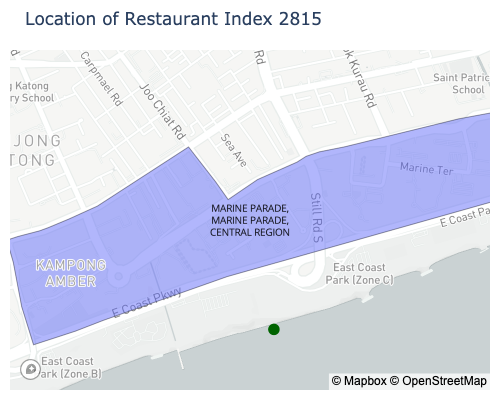

In [18]:
for res_id, region_id in [(2754, 323), (2537, 258), (2815, 93)]:
    gdf_subset_subzones = gdf_subzones[gdf_subzones.index == region_id]
    fig = px.choropleth_mapbox(
        gdf_subset_subzones,
        geojson=gdf_subset_subzones.geometry,
        locations=gdf_subset_subzones.index,
        opacity=0.5,
        zoom=13, # 11.2 for CBD  
        labels={'district': 'District', 'town': 'Town', 'area': 'Area'},
    )

    fig2 = go.Figure(go.Scattermapbox(
        mode="markers",
        lat=gdf_restaurant_missing_location['latitude'],
        lon=gdf_restaurant_missing_location['longitude'],
        marker= {"size": 12, "color": "darkgreen"},
    ))

    fig3 = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_subset_subzones.centroid.y,
        lon=gdf_subset_subzones.centroid.x,
        text=f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
    ))

    fig3.update_layout(
        width=500,
        height=400,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= gdf_subset_subzones.iloc[0,:].geometry.centroid.y,
                lon= gdf_subset_subzones.iloc[0,:].geometry.centroid.x,        
            ), zoom=14),        
        title=f"Location of Restaurant Index {res_id}",
        margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
        mapbox_accesstoken=mapbox_token,
        # mapbox= {'style': 'outdoors'},
        showlegend=False,        
    )

    fig3.update_traces(
        mode="text", 
        text= 
        f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
        textfont=dict(size=10, color='black')
    )

    fig3.add_trace(fig2.data[0])
    fig3.add_trace(fig.data[0])

    fig3.show("png")

In [19]:
gdf_restaurant.loc[2537, 'district'] = 'CHANGI POINT'
gdf_restaurant.loc[2537, 'town'] = 'CHANGI'
gdf_restaurant.loc[2537, 'area'] = 'EAST REGION'

gdf_restaurant.loc[2754, 'district'] = 'NORTH COAST'
gdf_restaurant.loc[2754, 'town'] = 'WOODLANDS'
gdf_restaurant.loc[2754, 'area'] = 'NORTH REGION'

gdf_restaurant.loc[2815, 'district'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'town'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'area'] = 'CENTRAL REGION'

### Visualising Number of Restaurants in each Area 
- Area: North Region, North-East Region, East Region, Central Region, West Region

In [20]:
df_region_area_rating = gdf_restaurant.groupby(['area']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_area_rating.columns = df_region_area_rating.columns.droplevel(1)
df_region_area_rating.reset_index(drop=False, inplace=True)
df_region_area_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_area = gdf_subzones.dissolve(by='area').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_area_rating = df_region_area_rating.merge(gdf_area, on='area', how='left')
gdf_region_area_rating = gpd.GeoDataFrame(df_region_area_rating, geometry='geometry', crs='epsg:4326')

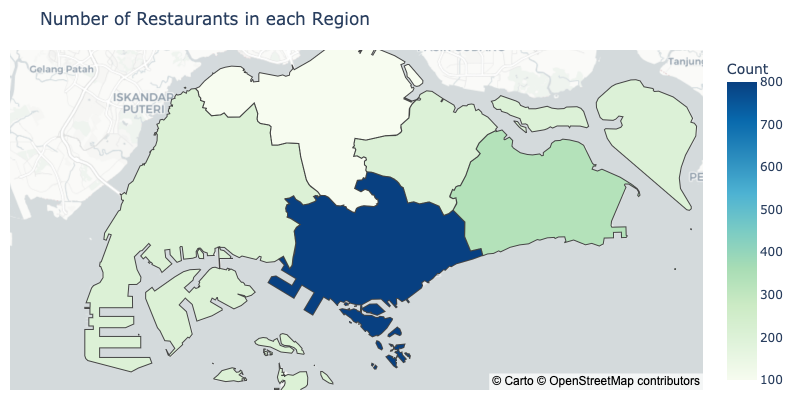

In [21]:
fig = px.choropleth_mapbox(
    gdf_region_area_rating,
    geojson = gdf_region_area_rating.geometry,
    locations = gdf_region_area_rating.index,
    labels={
        'num_of_restaurants': 'Count'
    },
    color='num_of_restaurants',
    color_continuous_scale='gnbu',
    range_color=(100,800),
    hover_data=['area'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png") # Can only be viewed on Notebooks
# fig.show('png') # To Render on GitHub

Central Region has overwhelmingly more restaurants than the North, North-East and West Region

### "Breaking Down" the Central and East Regions

In [22]:
df_region_town_rating = gdf_restaurant.groupby(['town']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_town_rating.columns = df_region_town_rating.columns.droplevel(1)
df_region_town_rating.reset_index(drop=False, inplace=True)
df_region_town_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_town = gdf_subzones.dissolve(by='town').reset_index(drop=False)[['town', 'area', 'geometry']]
gdf_region_town_rating = df_region_town_rating.merge(gdf_town, on='town', how='left')
gdf_region_town_rating = gpd.GeoDataFrame(gdf_region_town_rating, geometry='geometry', crs='epsg:4326')

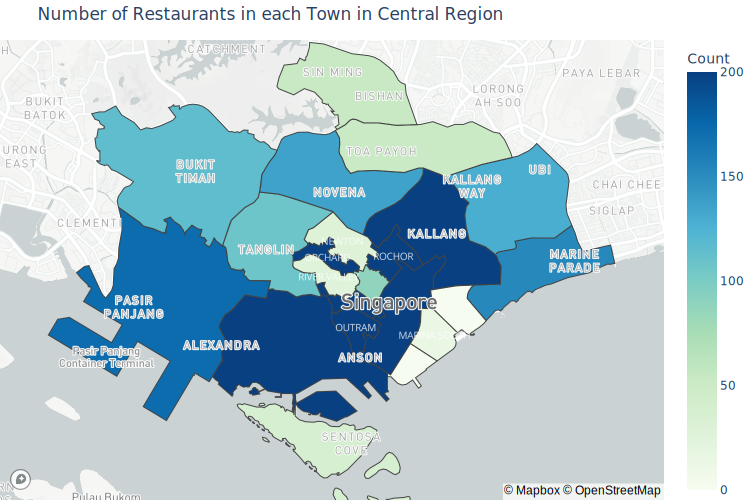

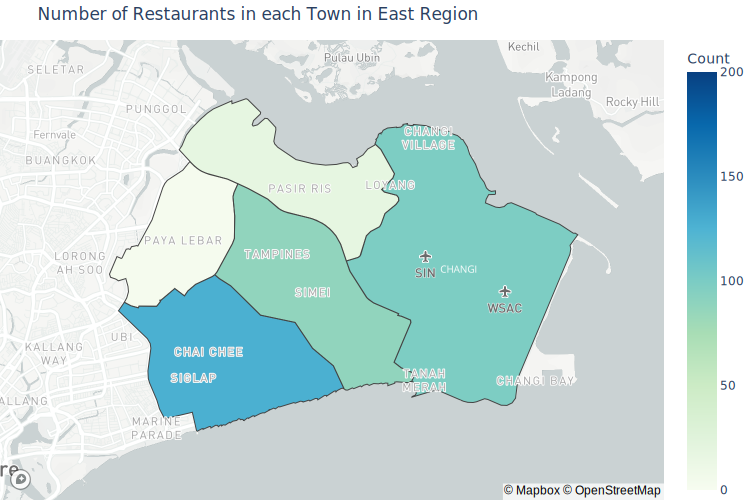

In [38]:
for i in [('CENTRAL REGION', 1.3, 103.835, 'Central'), ('EAST REGION', 1.35, 103.96, 'East')]:
    gdf_region_town_rating_subset = gdf_region_town_rating[gdf_region_town_rating['area'] == i[0]].copy()
    fig_text = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_region_town_rating_subset.centroid.y,
        lon=gdf_region_town_rating_subset.centroid.x,
        text=gdf_region_town_rating_subset['town'],
        textfont=dict(size=10, color='white')
    ))

    fig = px.choropleth_mapbox(
        gdf_region_town_rating_subset,
        geojson = gdf_region_town_rating_subset.geometry,
        locations = gdf_region_town_rating_subset.index,
        color='num_of_restaurants',
        color_continuous_scale='gnbu',
        range_color=(0,200),
        hover_data=['town', 'area'],
        labels={'num_of_restaurants': 'Count'}
    )    

    fig.update_layout(
        width=750,
        height=500,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= i[1],
                lon= i[2],
            ), zoom=11.2),
        mapbox_accesstoken=mapbox_token,
        title=f"Number of Restaurants in each Town in {i[3]} Region",
        margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
        showlegend=False,        
    )

    fig.add_traces(fig_text.data[0])
    fig.show("svg")

### Further Breaking Down Downtown Core into Districts

In [26]:
df_region_district_rating = gdf_restaurant.groupby(['district']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_district_rating.columns = df_region_district_rating.columns.droplevel(1)
df_region_district_rating.reset_index(drop=False, inplace=True)
df_region_district_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_district = gdf_subzones.dissolve(by='district').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_district_rating = df_region_district_rating.merge(gdf_district, on='district', how='left')
gdf_region_district_rating = gpd.GeoDataFrame(df_region_district_rating, geometry='geometry', crs='epsg:4326')

In [27]:
gdf_region_district_rating_downtown = gdf_region_district_rating[gdf_region_district_rating['town'] == 'DOWNTOWN CORE']

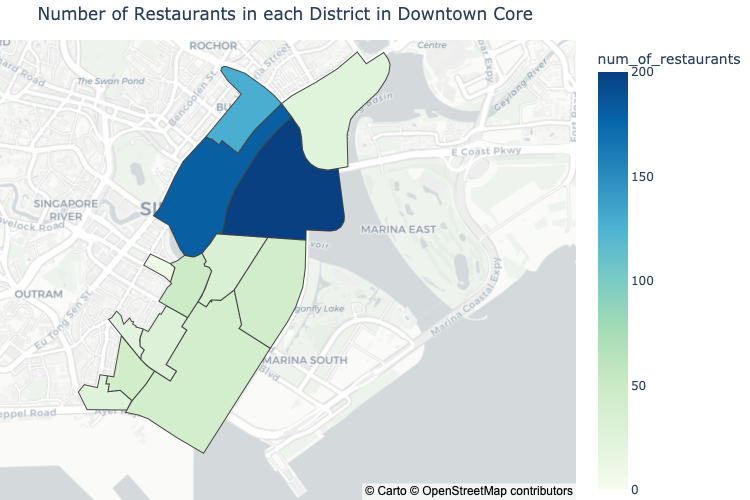

In [28]:
fig = px.choropleth_mapbox(
    gdf_region_district_rating_downtown,
    geojson = gdf_region_district_rating_downtown.geometry,
    locations = gdf_region_district_rating_downtown.index,
    color='num_of_restaurants',
    color_continuous_scale='gnbu',
    range_color=(0,200),
    hover_data=['town', 'area', 'district'],
    width=750,
    height=500,
    center= {
        'lat': 1.285,
        'lon': 103.86
    },
    zoom=12.95 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each District in Downtown Core",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

# BUGIS + CITY HALL
# MARINA CENTRE + NICOLL
# REMAINING --> Downtown Core

### Grouping District/Towns into "New" Region Lables

In [29]:
# ---------------------------------------------- #
gdf_town_paya_lebar_tampines_pasir_ris = gdf_town[gdf_town['town'].isin([
    'PAYA LEBAR', 'TAMPINES', 'PASIR RIS'])]

gdf_town_paya_lebar_tampines_pasir_ris = gdf_town_paya_lebar_tampines_pasir_ris.dissolve('area').reset_index(drop=False)
gdf_town_paya_lebar_tampines_pasir_ris.loc[0, 'town'] = 'PAYA LEBAR, TAMPINES, PASIR RIS'

# ---------------------------------------------- #
gdf_town_bishan_toa_payoh = gdf_town[gdf_town['town'].isin([
    'BISHAN', 'TOA PAYOH'])]

gdf_town_bishan_toa_payoh = gdf_town_bishan_toa_payoh.dissolve('area').reset_index(drop=False)
gdf_town_bishan_toa_payoh.loc[0, 'town'] = 'BISHAN, TOA PAYOH'

# ---------------------------------------------- #
gdf_town_rochor = gdf_town[gdf_town['town'].isin([
    'MUSEUM', 'ROCHOR'])]

gdf_town_rochor = gdf_town_rochor.dissolve('area').reset_index(drop=False)
gdf_town_rochor.loc[0, 'town'] = 'ROCHOR'

# ---------------------------------------------- #
gdf_town_singapore_river = gdf_town[gdf_town['town'].isin([
    'RIVER VALLEY', 'SINGAPORE RIVER'])]

gdf_town_singapore_river = gdf_town_singapore_river.dissolve('area').reset_index(drop=False)
gdf_town_singapore_river.loc[0, 'town'] = 'SINGAPORE RIVER'

# ---------------------------------------------- #
gdf_town_newtown_orchard = gdf_town[gdf_town['town'].isin([
    'NEWTON', 'ORCHARD'])]

gdf_town_newtown_orchard = gdf_town_newtown_orchard.dissolve('area').reset_index(drop=False)
gdf_town_newtown_orchard.loc[0, 'town'] = 'NEWTON, ORCHARD'

# ---------------------------------------------- #
gdf_town_bukit_merah_southern_islands = gdf_town[gdf_town['town'].isin([
    'BUKIT MERAH', 'SOUTHERN ISLANDS'])]

gdf_town_bukit_merah_southern_islands = gdf_town_bukit_merah_southern_islands.dissolve('area').reset_index(drop=False)
gdf_town_bukit_merah_southern_islands.loc[0, 'town'] = 'BUKIT MERAH, SOUTHERN ISLANDS'

# ---------------------------------------------- #
gdf_town_marina_bay = gdf_town[gdf_town['town'].isin([
    'MARINE PARADE', 'MARINA EAST', 'MARINA SOUTH', 'STRAITS VIEW'])]

gdf_town_marina_bay = gdf_town_marina_bay.dissolve('area').reset_index(drop=False)
gdf_town_marina_bay.loc[0, 'town'] = 'MARINA BAY'

# ---------------------------------------------- #
gdf_district_bugis_city_hall = gdf_district[gdf_district['district'].isin([
    'BUGIS', 'CITY HALL'])]

gdf_district_bugis_city_hall = gdf_district_bugis_city_hall.dissolve('area').reset_index(drop=False)
gdf_district_bugis_city_hall.loc[0, 'district'] = 'BUGIS, CITY HALL'

# ---------------------------------------------- #
gdf_district_marina_centre = gdf_district[gdf_district['district'].isin([
    'NICOLL', 'MARINA CENTRE'])]

gdf_district_marina_centre = gdf_district_marina_centre.dissolve('area').reset_index(drop=False)
gdf_district_marina_centre.loc[0, 'district'] = 'MARINA CENTRE'

# ---------------------------------------------- #
gdf_district_downtown = gdf_district[
    ~(gdf_district['district'].isin(['NICOLL', 'MARINA CENTRE', 'BUGIS', 'CITY HALL'])) &
    (gdf_district['town'] == 'DOWNTOWN CORE')
]

gdf_district_downtown = gdf_district_downtown.dissolve('area').reset_index(drop=False)
gdf_district_downtown.loc[0, 'district'] = 'DOWNTOWN'

### Existing District/Town/Area

In [30]:
gdf_area_excluding_central_east = gdf_area[~gdf_area['area'].isin(['EAST REGION', 'CENTRAL REGION'])]
gdf_area_excluding_central_east = gdf_area_excluding_central_east[['geometry', 'area']].rename(columns={'area': 'new_region_feature'})

# ---------------------------------------------- #
gdf_town_changi_bedok = gdf_town[gdf_town['town'].isin([
                                'CHANGI', 'BEDOK'])]

gdf_town_changi_bedok = gdf_town_changi_bedok[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})                               

# ---------------------------------------------- #
gdf_town_central =gdf_town[
    (gdf_town['area'] == 'CENTRAL REGION') &
    ~(gdf_town['town'].isin([
        'BISHAN', 'TOA PAYOH', 'MUSEUM', 'ROCHOR', 'RIVER VALLEY',
        'SINGAPORE RIVER', 'NEWTON', 'ORCHARD', 'MARINE PARADE', 'MARINA EAST',
        'MARINA SOUTH', 'STRAITS VIEW', 'BUKIT MERAH', 'SOUTHERN ISLANDS','DOWNTOWN CORE'
    ]))
]

gdf_town_central = gdf_town_central[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})

### Creation of New Feature and Merging into Restaurant Data

In [31]:
gdf_new_region = pd.concat([
    gdf_area_excluding_central_east,
    gdf_town_changi_bedok,
    gdf_town_central,
    gdf_town_paya_lebar_tampines_pasir_ris[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bishan_toa_payoh[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_rochor[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_singapore_river[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_newtown_orchard[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bukit_merah_southern_islands[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_marina_bay[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_district_bugis_city_hall[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_marina_centre[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_downtown[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
])

gdf_new_region.reset_index(drop=True, inplace=True)

In [32]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_new_region,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)
gdf_restaurant.loc[2537, 'new_region_feature'] = 'CHANGI'
gdf_restaurant.loc[2754, 'new_region_feature'] = 'NORTH REGION'
gdf_restaurant.loc[2815, 'new_region_feature'] = 'MARINA BAY'

In [33]:
df_new_region = gdf_restaurant.groupby(['new_region_feature']).agg({
    'url': ['count'],
    'mall': ['count'],
    'walking_distance': ['mean'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_new_region.columns = df_new_region.columns.droplevel(1)
df_new_region.reset_index(drop=False, inplace=True)
df_new_region.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

In [34]:
gdf_new_region = gdf_new_region.merge(df_new_region, on='new_region_feature', how='left')

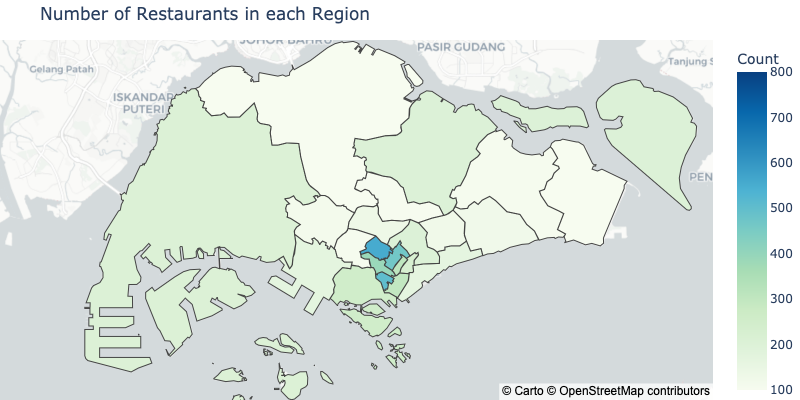

In [35]:
fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='num_of_restaurants',
    color_continuous_scale='gnbu',
    range_color=(100,800),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'num_of_restaurants': 'Count'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

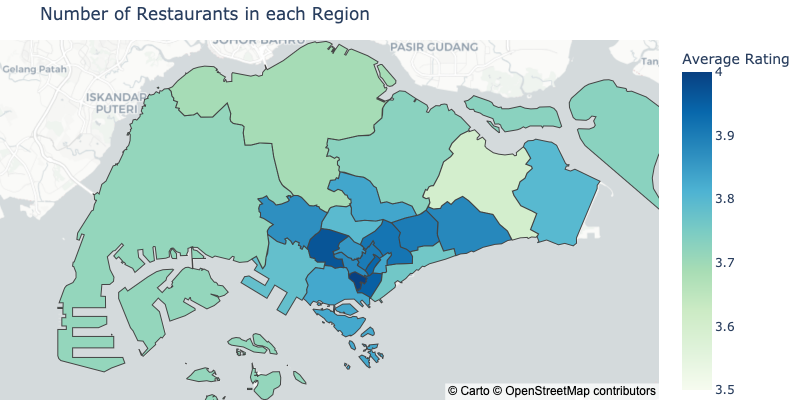

In [36]:
fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='average_rating',
    color_continuous_scale='gnbu',
    range_color=(3.5,4),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'average_rating': 'Average Rating'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")